# Basic visualizations for Power Laws data

In [1]:
%matplotlib inline
%load_ext autoreload
%load_ext watermark

In [2]:
import sys
import os
sys.path.append(os.path.join("..", "src"))

In [3]:
%autoreload 2
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import numpy as np
import seaborn as sns
import re
import os
import sys
import subprocess
import logging
import itertools
from sklearn import metrics
from collections import defaultdict
from IPython.display import HTML, Image, display
import ipywidgets as widgets

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%I:%M:%S', stream=sys.stdout)
sns.set(style="white", font_scale=1.5)

In [4]:
%watermark -a "Tomasz Waleń" -u -n -t -z -m -v -p pandas,numpy,matplotlib,seaborn

Tomasz Waleń 
last updated: Thu Nov 08 2018 16:43:39 CET

CPython 3.6.7
IPython 6.5.0

pandas 0.23.4
numpy 1.15.1
matplotlib 2.2.3
seaborn 0.9.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 9.1.0 (clang-902.0.39.2)
system     : Darwin
release    : 17.5.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [5]:
# Settings
INPUT_FILENAME = "../data/interim/train_test.hdf5"

In [6]:
# Reading data
train_test = pd.read_hdf(INPUT_FILENAME, "train_test")
train_test_d = pd.read_hdf(INPUT_FILENAME, "train_test_d")
series = pd.read_hdf(INPUT_FILENAME, "series")
meta = pd.read_hdf(INPUT_FILENAME, "meta")
submission = pd.read_hdf(INPUT_FILENAME, "submission")
# train_test.tail(3).transpose()

# Basic stats

In [9]:
display(train_test.groupby('entry_type').size().rename("data points count").to_frame())
display(train_test.groupby('entry_type')['series_id'].nunique().rename("series count").to_frame())
display(series.groupby(['is_train', 'is_clean']).size().rename("series count").to_frame())

,data points count
entry_type,
cold_start,111984
test,7529
train,509376


,series count
entry_type,
cold_start,625
test,625
train,758


series count
is_train is_clean              
False    False               15
         True               610
True     False               40
         True               718

In [10]:
cols = ['date', 'consumption', 'temperature', 'series_id']
pd.concat([
    train_test[cols].min().rename("min"),
    train_test[cols].max().rename("max"),
    train_test[cols].count().rename("count"),
], axis=1).round(1)

,min,max,count
date,2012-06-01 00:00:00,2017-12-29 00:00:00,628889
consumption,0,5.36617e+06,621360
temperature,-13.4667,44.35,352334
series_id,100003,103634,628889


# plots

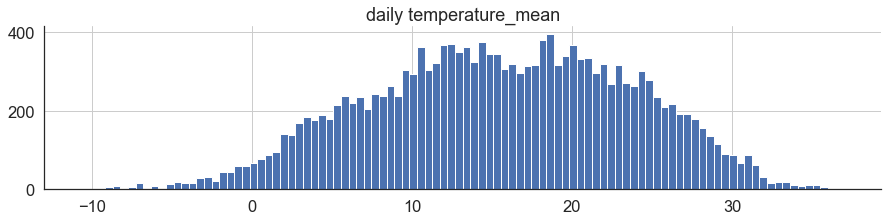

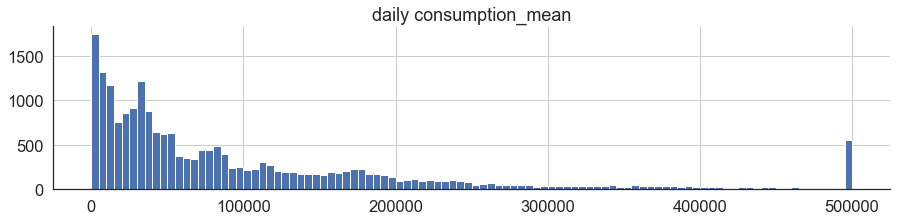

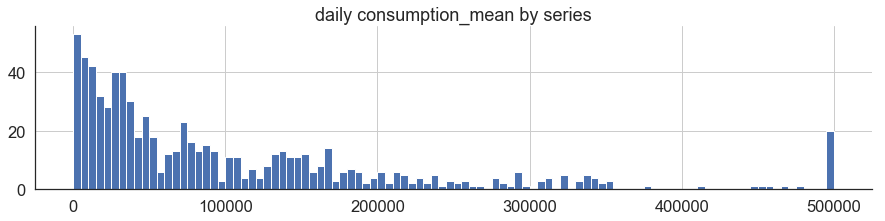

In [13]:
train_test_d['temperature_mean'].hist(bins=100, figsize=(15, 3)).set(title="daily temperature_mean")
sns.despine()
plt.show()

train_test_d[train_test_d.entry_type=='train']\
    ['consumption_mean'].clip(0, 5*10**5)\
    .hist(bins=100, figsize=(15, 3)).set(title="daily consumption_mean")
sns.despine()
plt.show()


sel = train_test_d[train_test_d.entry_type=='train']
g = sel.groupby('series_id')['consumption_mean'].mean()
g.clip(0, 5*10**5).hist(bins=100, figsize=(15, 3)).set(title="daily consumption_mean by series")
sns.despine()
plt.show()

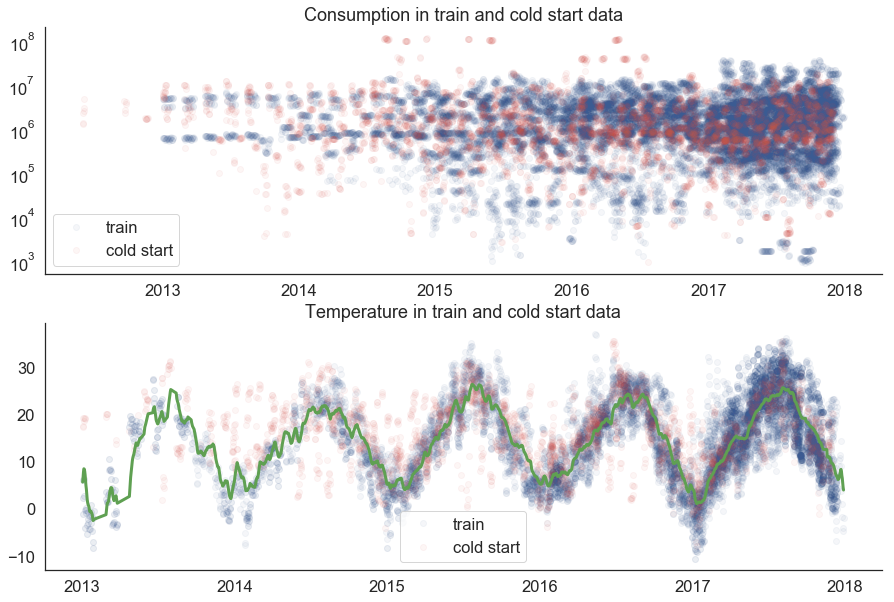

In [15]:
fig, axs = plt.subplots(figsize=(15, 10), nrows=2)
sel = train_test_d[train_test_d.entry_type.isin(['train', 'cold_start'])]
for e in ['train', 'cold_start']:
    s = sel[sel.entry_type==e]
    c = {"train": sns.xkcd_rgb['denim blue'], "cold_start": sns.xkcd_rgb['pale red']}.get(e)
    axs[0].plot(s.date, s.consumption, 'o', color=c, alpha=0.05)
    sns.despine(ax=axs[0])
    axs[1].plot(s.date, s.temperature_mean, 'o', color=c, alpha=0.05)
    sns.despine(ax=axs[1])

axs[0].set_yscale("log", nonposy='clip')
axs[0].set_title("Consumption in train and cold start data")
axs[0].legend(['train', 'cold start'])
    
g = sel.groupby('date', as_index=False)['temperature_mean'].mean()
g['temperature_mean2'] = g['temperature_mean'].ewm(10).mean()
axs[1].plot(g.date, g.temperature_mean2, '-', color=sns.xkcd_rgb['muted green'], linewidth=3)
axs[1].set_title("Temperature in train and cold start data")
axs[1].legend(['train', 'cold start'])
   
plt.show()

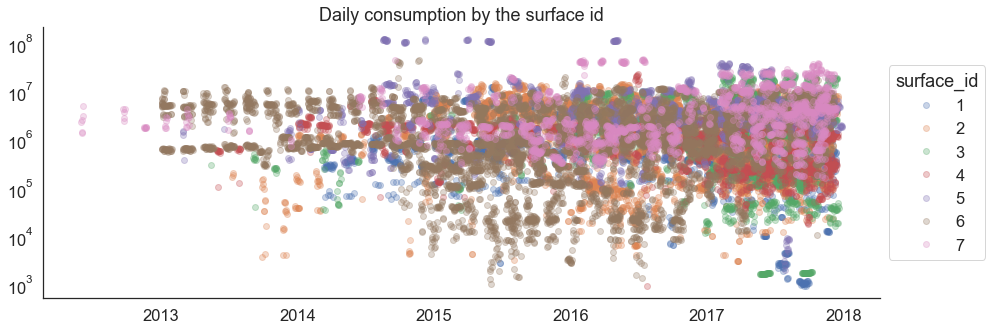

In [18]:
fig, ax = plt.subplots(figsize=(15, 5))
sel = train_test_d[train_test_d.entry_type.isin(['train', 'cold_start'])]
legend = []
for surface_id, s in sel.groupby('surface_id'):
    ax.plot(s.date, s.consumption, 'o', alpha=0.3)
    legend.append(str(surface_id))
ax.legend(legend, bbox_to_anchor=(1, 0.5), title='surface_id', loc='center left')
ax.set_title("Daily consumption by the surface id")

ax.set_yscale("log", nonposy='clip')
sns.despine(ax=ax)
   
plt.show()

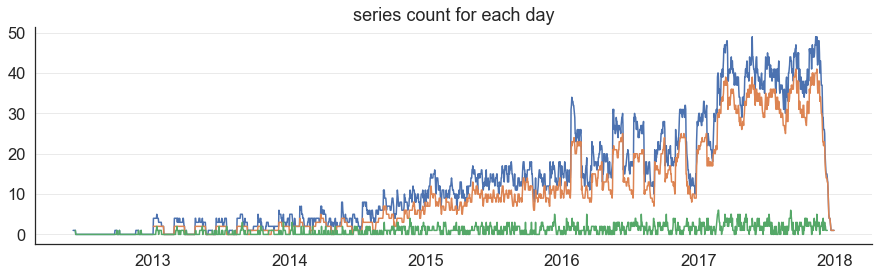

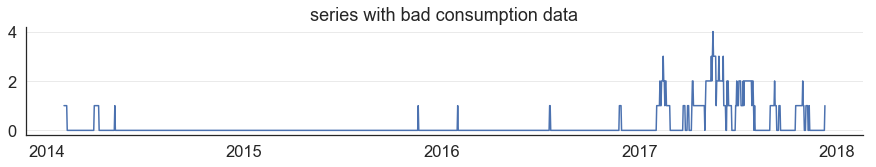

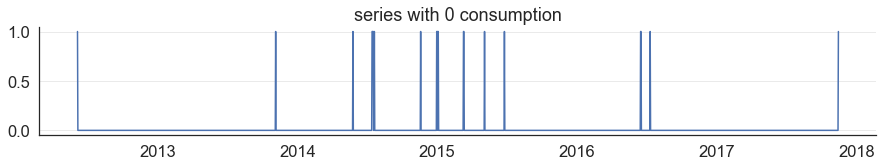

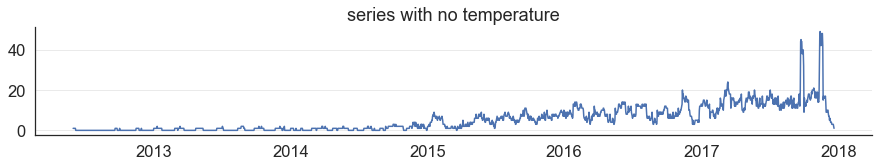

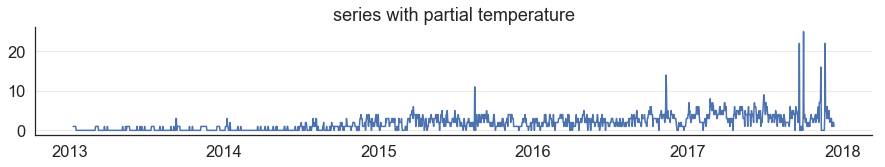

In [14]:
def plot_counts_by_date(df, title=None, figsize=(15, 2), ax=None, show=True):
    g = df.groupby('date').size()
    g = g.reindex(pd.date_range(g.index.min(), g.index.max())).fillna(0)
    ax = g.plot(kind='line', figsize=figsize, ax=ax)
    if title is not None:
        ax.set_title(title)
    ax.yaxis.grid(True, alpha=0.4)
    sns.despine(ax=ax)
    if show:
        plt.show()
    else:
        return ax

ax = plot_counts_by_date(train_test_d, "series count for each day", figsize=(15, 4), show=False)
ax = plot_counts_by_date(train_test_d[train_test_d.entry_type=='train'], title=None, ax=ax, figsize=None, show=False)
plot_counts_by_date(train_test_d[train_test_d.entry_type=='test'], title=None, ax=ax, figsize=None, show=True)

plot_counts_by_date(train_test_d[train_test_d['is_invalid_consumption']], "series with bad consumption data")
plot_counts_by_date(train_test_d[train_test_d['has_zero_consumption']], "series with 0 consumption")
plot_counts_by_date(train_test_d[~train_test_d['has_some_temperature']], "series with no temperature")
plot_counts_by_date(train_test_d[train_test_d['has_some_temperature'] & ~train_test_d['has_full_temperature']], "series with partial temperature")

In [19]:
sel_series = series[(series.is_train) & (series.is_clean)].index
sel = train_test[train_test.series_id.isin(sel_series)]
def p1(x):
    return np.percentile(x, 1.0)
def p15(x):
    return np.percentile(x, 15.0)
def p85(x):
    return np.percentile(x, 85.0)
def p99(x):
    return np.percentile(x, 99.0)

print("calculating percentiles of consumption for different surface ids")
g = sel.groupby('surface_id').agg({
    'consumption': [np.min, p1, p15, np.mean, p85, p99, np.max]
}).round(0)
display(g)

calculating percentiles of consumption for different surface ids


consumption                                                   \
                  amin       p1      p15      mean       p85        p99   
surface_id                                                                
1                  7.0     20.0   3867.0   52974.0  101131.0   335961.0   
2                 37.0    500.0  12660.0  110354.0  223849.0   561668.0   
3                 68.0     71.0   4137.0  151971.0  337881.0   936309.0   
4               1012.0   2461.0   5033.0   50263.0  125787.0   200933.0   
5               3752.0  59941.0  84382.0  229767.0  354614.0  1312847.0   
6                 20.0    135.0   3760.0   81302.0  173086.0   732860.0   
7               3038.0   7479.0  22518.0  193432.0  430045.0  1279949.0   

                       
                 amax  
surface_id             
1            764033.0  
2            707243.0  
3           1228276.0  
4            338907.0  
5           2085109.0  
6           1149910.0  
7           2078015.0

sample consumption data for date range 2017-05-07 - 2017-05-20


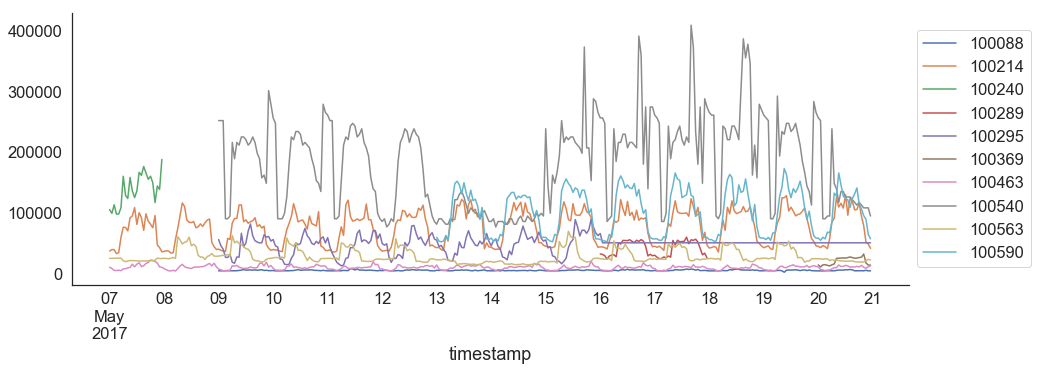

In [21]:
print("sample consumption data for date range 2017-05-07 - 2017-05-20")
sel_days = pd.date_range("2017-05-07", "2017-05-20")
sel = train_test[(train_test.date.isin(sel_days)) & (train_test.consumption.notnull())]
g = sel.groupby(['timestamp', 'series_id'])['consumption'].sum().unstack(level=1)
# g = g.ewm(2, axis=0).mean()
ax = g.iloc[:, :10].plot(kind='line', figsize=(15, 5))
ax.legend(bbox_to_anchor=(1, 0.5), loc="center left")
sns.despine()
plt.show()

sample consumption data 3 random series


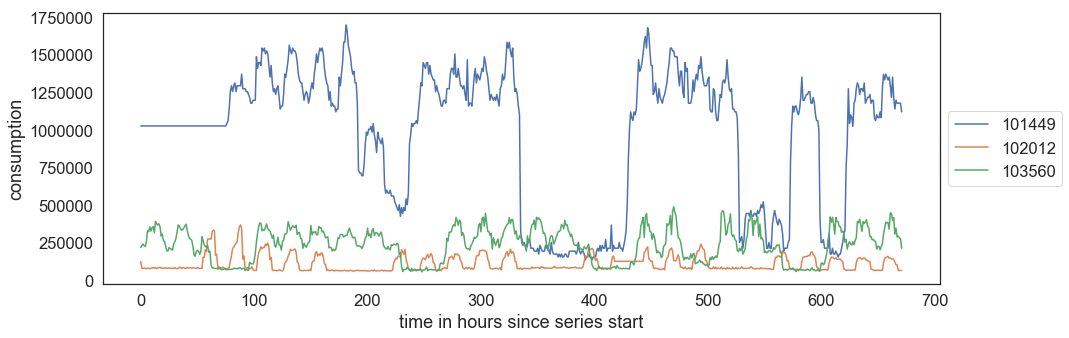

In [22]:
print("sample consumption data 3 random series")
sel_ids = train_test[
    (train_test.entry_type=='train')
    & (train_test.surface_id==5)
]['series_id'].sample(3, random_state=0)
sel = train_test[train_test.series_id.isin(sel_ids)]
g = sel.groupby(['h_num', 'series_id'])['consumption'].sum().unstack(level=1)
ax = g.plot(kind='line', figsize=(15, 5))
ax.legend(bbox_to_anchor=(1, 0.5), loc="center left")
ax.set_xlabel("time in hours since series start")
ax.set_ylabel("consumption")
plt.show()

,series_id,date,consumption_min,consumption_p125,consumption_mean,consumption_p875,consumption_max
0,100003,2017-10-24,187969.954324,187969.954324,221824.757925,254668.970374,281954.931486
1,100003,2017-10-25,191001.727781,191001.727781,221319.462349,255426.913739,266796.064202
2,100003,2017-10-26,191001.727781,194033.501238,221824.757925,248984.395143,266796.064202
3,100003,2017-10-27,194033.501238,194033.501238,223466.968548,249363.366825,284986.704943
4,100003,2017-10-28,191001.727781,191001.727781,195170.416284,197065.274694,200097.048151
5,100003,2017-10-29,187969.954324,187969.954324,190812.241940,194033.501238,197065.274694
6,100003,2017-10-30,187969.954324,187969.954324,222456.377395,255426.913739,278923.158029


historogram of consumption_p0.875 / consumption_p0.125


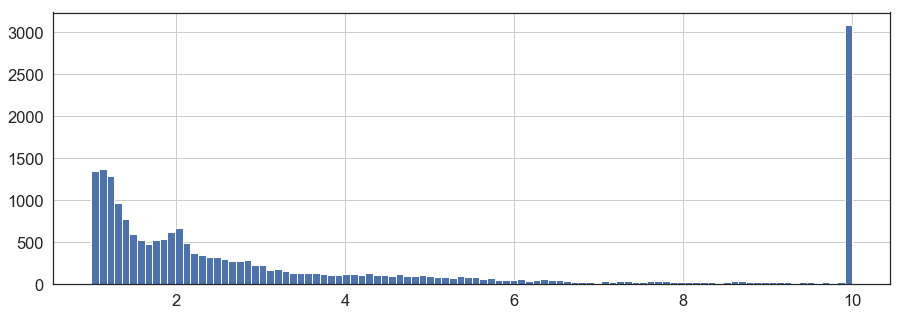

In [23]:
sel = train_test_d[train_test_d.entry_type=='train']
g = sel[['series_id', 'date', 'consumption_min', 'consumption_p125', 'consumption_mean', 'consumption_p875', 'consumption_max']]
display(g.head(7))

print("historogram of consumption_p0.875 / consumption_p0.125")
(g['consumption_p875'] / g['consumption_p125']).clip(0, 10).hist(bins=100, figsize=(15, 5))
plt.show()

# Interactive

In [25]:
def show_series(series_id="101449"):
    series_id = int(series_id)
    gh = train_test[(train_test.series_id==series_id) & (train_test.entry_type.isin(['train', 'cold_start']))]
    gd = train_test_d[(train_test_d.series_id==series_id) & (train_test_d.entry_type.isin(['train', 'cold_start']))]
    
    if len(gh)==0:
        return
    
    display(gd[['date', 'consumption_mean', 'consumption_min', 'temperature_mean']].head(3))
    
    fig, axs = plt.subplots(figsize=(15, 9), sharex=False, nrows=3)

    ax = axs[0]
    gh.plot(kind='line', ax=ax, x='timestamp', y='consumption', legend=False)
    g = gh.groupby('timestamp')['consumption'].first()
    g.rolling(3).mean().plot(kind='line', ax=ax)
    g.ewm(3).mean().plot(kind='line', ax=ax)
    g = gh.groupby('timestamp')['is_day_off'].first().map(lambda x: 1 if x==True else None)
    if any(g.notnull()):
        g.plot(kind='line', ax=ax, linewidth=3)
    ax.set_title("consumption")
    ax.set_xlabel("")

    ax = axs[1]
    if any(gh['temperature'].notnull()):
        gh.plot(kind='line', ax=ax, x='timestamp', y='temperature', legend=False)
        gh.groupby('timestamp')['temperature'].first().ewm(3).mean().plot(kind='line', ax=ax)
    ax.set_title("temperature")
    ax.set_xlabel("")

    ax = axs[2]    
    gd.plot(kind='line', ax=ax, x='timestamp', y=['consumption_mean', 'consumption_p125', 'consumption_p875'], legend=False)
    ax.set_title("avg consumption (within single day)")
    ax.set_xlabel("")
    
    for ax in axs:
        sns.despine(ax=ax)
        ax.yaxis.grid(True, alpha=0.4)
    
    plt.tight_layout()
    plt.show()

    
widgets.interactive(show_series)

interactive(children=(Text(value='101449', description='series_id'), Output()), _dom_classes=('widget-interact…

In [26]:
def show_combined_hourly_usage(series_id="101449"):
    series_id = int(series_id)
    sel = train_test[train_test.series_id==series_id]
    g = sel.groupby([
        sel['h_num'] % 24,
        sel['date'],
    ])['consumption'].sum().unstack(level=1)
    fig, ax = plt.subplots(figsize=(15, 4))
    is_day_off = g.columns.map(sel.groupby('date')['is_day_off'].first())
    is_holiday_us = g.columns.map(sel.groupby('date')['is_holiday_us'].first())
    is_holiday_fra = g.columns.map(sel.groupby('date')['is_holiday_fra'].first())
    is_holiday_au = g.columns.map(sel.groupby('date')['is_holiday_au'].first())
    color = []
    for i in range(len(g.columns)):
        curr = sns.xkcd_rgb['denim blue']
        if is_day_off[i]:
            curr = sns.xkcd_rgb['pale red']
        elif is_holiday_us[i] or is_holiday_fra[i] or is_holiday_au[i]:
            curr = sns.xkcd_rgb['muted green']
        color.append(curr)
    display(g.transpose().head(5).round(1))
    g.iloc[:, :10].plot(kind='line', ax=ax, color=color, legend=None)
    plt.show()

widgets.interactive(show_combined_hourly_usage)

interactive(children=(Text(value='101449', description='series_id'), Output()), _dom_classes=('widget-interact…

In [27]:
def show_hourly_usage_for_single_day(day="2017-04-22", normalize=False):
    day = pd.to_datetime(day)
    sel = train_test[(train_test['date']==day) & (train_test.entry_type.isin(['train', 'cold_start']))]
    print(sorted(sel.series_id.unique()))
    g = sel.groupby([
        sel['h_num'] % 24,
        sel['series_id'],
    ])['consumption'].sum().unstack(level=1)
    t = sel.groupby([
        sel['h_num'] % 24,
        sel['series_id'],
    ])['temperature'].sum().unstack(level=1)
    if normalize:
        g = g.divide(g.min(axis=0), axis=1).clip(0, 5)
    corr = g.corr()
    t_corr = t.corr()
    fig, axs = plt.subplots(figsize=(12, 6), ncols=2)
    sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=axs[0])
    sns.heatmap(t_corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=axs[1])
    plt.tight_layout()
    plt.show()
    fig, ax = plt.subplots(figsize=(15, 4))
    color = sns.xkcd_rgb['denim blue']
    g.plot(kind='line', ax=ax, alpha=0.4, legend=None)
    plt.show()

widgets.interactive(show_hourly_usage_for_single_day)

interactive(children=(Text(value='2017-04-22', description='day'), Checkbox(value=False, description='normaliz…

# Identify series with invalid consumption data

In [28]:
sel = train_test_d[train_test_d.entry_type.isin(['train', 'cold_start'])]
sel = sel[sel.consumption_max / sel.consumption_min < 1.00001]
print(len(sel), sel['series_id'].nunique(), sel['date'].nunique())
sel.groupby('series_id', as_index=False).first()\
[['series_id', 'date', 'consumption_min', 'consumption_max', 'is_day_off', 'entry_type']].head(50)

280 43 199


,series_id,date,consumption_min,consumption_max,is_day_off,entry_type
0,100111,2017-06-28,2.793766e+04,2.793766e+04,False,cold_start
1,100175,2017-11-08,8.013729e+04,8.013729e+04,False,train
2,100245,2014-02-02,2.636250e+04,2.636250e+04,True,cold_start
3,100287,2017-06-05,6.750862e+01,6.750862e+01,False,train
4,100295,2017-05-17,5.019119e+04,5.019119e+04,False,train
5,100296,2014-03-30,2.512764e+04,2.512764e+04,True,cold_start
6,100304,2017-02-20,8.608631e+04,8.608631e+04,False,train
7,100376,2016-07-19,1.124760e+04,1.124760e+04,False,cold_start
8,100604,2017-05-16,6.729339e+03,6.729339e+03,False,train
9,100794,2017-07-04,5.019119e+04,5.019119e+04,False,train


# Searching for possible holidays from consumption data

In [30]:
sel = train_test_d[train_test_d.is_day_off]
limits = pd.concat([
    train_test_d.groupby('series_id')['consumption'].min().rename("series_consumption_min"),
    train_test_d.groupby('series_id')['consumption'].max().rename("series_consumption_max"),
    sel.groupby(['series_id', 'dayofweek'])['consumption'].max().unstack(level=1).min(axis=1).rename("series_est_consumption_day_off"),
], axis=1)    
tmp = train_test_d.join(limits, on='series_id', how='left')
possible_holidays = tmp[
    ~(tmp.is_day_off)
    &
    (tmp.series_consumption_min * 2 <= tmp.series_consumption_max)
    &
    (tmp.consumption <= tmp['series_est_consumption_day_off'])
]
possible_holidays.groupby('date').size().sort_values(ascending=False)\
.rename("number of series with low consumption")\
.to_frame().head(10)

,number of series with low consumption
date,
2017-04-17,17
2017-01-02,14
2016-12-26,14
2017-05-01,12
2017-02-27,10
2016-12-28,10
2017-08-15,9
2017-01-06,8
2016-12-27,8
